# DM project

### **Caution: As for convenience, the main process is at front while built functions and functions are defined at back. Thus please firstly run the code at Section "Built Functions", then go through the main process

## Main Process

In [2]:
# Dependencies loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import  sent_tokenize,word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import nltk

### Read and Preprocess raw data

#### Stop words initialization

In [15]:
stop_words = set(stopwords.words('english'))
# remove following lines if you need punctuation 
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])

#### Load data

In [16]:
# read train data
df_traindata = pd.read_excel('Data/train.xlsx')
df_traindata.dropna(inplace=True)

# load original text and label as dataframe
df_traindata_text = df_traindata['text']
df_traindata_label = df_traindata['label']


print(df_traindata.head())

                                                text  label
0  Fiskars has a strong portfolio of internationa...      1
1  METALS-Zinc surges 12 pct after Glencore cuts ...      1
2  According to Scanfil , demand for telecommunic...     -1
3  dbs launches new banking api developer platfor...      1
4  Theodosopoulos said Tellabs could be of value ...      1


In [17]:
# Load LM-dictionary data
# read excel data as numpy array
words_Negative = np.array(pd.read_excel('Data/LoughranMcDonald_SentimentWordLists_2018.xlsx', 
                   sheet_name='Negative', header=None)).reshape(-1,).tolist()
words_Positive = np.array(pd.read_excel('Data/LoughranMcDonald_SentimentWordLists_2018.xlsx', 
                   sheet_name='Positive', header=None)).reshape(-1,).tolist()
words_Uncertainty = np.array(pd.read_excel('Data/LoughranMcDonald_SentimentWordLists_2018.xlsx', 
                   sheet_name='Uncertainty', header=None)).reshape(-1,).tolist()
words_Litigious = np.array(pd.read_excel('Data/LoughranMcDonald_SentimentWordLists_2018.xlsx', 
                   sheet_name='Litigious', header=None)).reshape(-1,).tolist()
words_StrongModal = np.array(pd.read_excel('Data/LoughranMcDonald_SentimentWordLists_2018.xlsx', 
                   sheet_name='StrongModal', header=None)).reshape(-1,).tolist()
words_WeakModal = np.array(pd.read_excel('Data/LoughranMcDonald_SentimentWordLists_2018.xlsx', 
                   sheet_name='WeakModal', header=None)).reshape(-1,).tolist()
words_Constraining = np.array(pd.read_excel('Data/LoughranMcDonald_SentimentWordLists_2018.xlsx', 
                   sheet_name='Constraining', header=None)).reshape(-1,).tolist()

#### Preprocess

In [18]:
# DO Preprocess with data-cleaning

# preprocess text dataset with cleaning
train_data_text = [clean_tokenize_text(i) 
                  for i in df_traindata_text]

# preprocess label dataset to np.array
train_data_label = np.array(df_traindata_label)

#After preprocess, text and label data are all in np.array

In [19]:
# transfer it into hash map for fast reading rather than loop finding
dict_neg = {word.lower():-1 for word in words_Negative} #the value of key could be changed
dict_pos = {word.lower():1 for word in words_Positive}
dict_words = merge_two_dict(dict_neg,dict_pos)

### Models Test

#### Model 1: Lexcon-based Model

In [20]:
model1 = model_LB(dict_pos,dict_neg,0.1) # Initialize model

In [21]:
# do the F1 score finding with threshold changing
# This process is just like hyper-parameter selecting
thresholds = np.linspace(-0.5,0.5,10)
F1_buf = []
acc_buf = []
for threshold in thresholds:
    model1.threshold = threshold # change the parameter for model1
    f1_new,confusion_mat = F1(train_data_text,train_data_label,model1)
    acc_new = accuracy(train_data_text,train_data_label,model1)
    
    F1_buf += [f1_new]
    acc_buf += [acc_new]
    #print(confusion_mat)

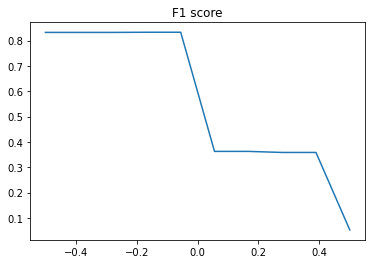

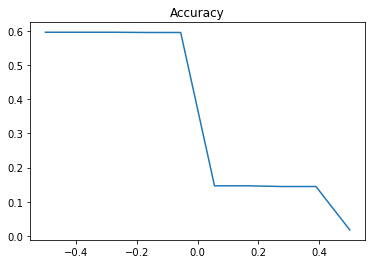

In [22]:
plt.plot(thresholds,F1_buf)
plt.title('F1 score')
plt.show()

plt.plot(thresholds,acc_buf)
plt.title('Accuracy')
plt.show()

#### Model 2: Statistical Model

#### Model 3: Further Model

## Built Functions

### Preprocess Functions

In [8]:
def get_wordnet_pos(treebank_tag):
    # transfer nltk pos tag to wordnet postag
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def clean_tokenize_text(text,remove_stopwords=True):# 是否移除
 
    """
    Clean and tokenize text into words
    """
    #Step1:tokenize
    words = word_tokenize(text)
    #Step2:pos tagging
    word_tags = nltk.pos_tag(words)

    wnl = WordNetLemmatizer()
    filtered_words=[]
    
    for word_tag in word_tags:   
        wornet_tag = get_wordnet_pos(word_tag[1])
         #step3: Lemmatization or stemming
        word_lemma = wnl.lemmatize(word_tag[0],pos=wornet_tag)
        #step4: normalize case
        low_word_lemma = word_lemma.lower()
         #step5: remove stop words
        if remove_stopwords and low_word_lemma in stop_words: 
            continue
        filtered_words.append(low_word_lemma)
    # count word fequency
    return filtered_words
def merge_two_dict(a,b):
    c = a.copy()
    c.update(b)
    return c

### Predict Functions for different models
#### Notes:  Only have to build predict() functions in model class. This is for standard evaluation process.

In [9]:
# Build Model class for structed data
class model():
    def __init__(self):
        self.predict = None #would be re-constructed

### Model 1 : Lexicon-based Model

In [10]:
class model_LB(model):
    def __init__(self,dict_pos,dict_neg,threshold = 0):
        self.dict_pos = dict_pos
        self.dict_neg = dict_neg
        self.threshold = threshold
        
    def pos_count(self,text):
        pos_count = 0
        for word in text:
            pos_count += (word in self.dict_pos)
        return pos_count

    def neg_count(self,text):
        neg_count = 0
        for word in text:
            neg_count += (word in self.dict_neg)
        return neg_count
    
    def sentiment_score(self,text):
        pos = self.pos_count(text)
        neg = self.neg_count(text)
        return (pos - neg)/(pos + neg + 1)
    
    def predict(self,text):
        return self.sentiment_score(text) > self.threshold
        

### Model 2: Statistical Model

### Model 3: Further Model

### Evaluation Functions

In [11]:
def accuracy(train_data_text,train_data_label,model):
    correct_score = 0 
    for i,text in enumerate(train_data_text):
        correct_score += model.predict(text) == train_data_label[i]
    return correct_score/len(train_data_text)

def F1(train_data_text,train_data_label,model):
    tp = fp = fn = tn = 0
    for i,text in enumerate(train_data_text):
        label_new = train_data_label[i] == 1
        predict_new = model.predict(text)
        if label_new and predict_new:
            tp += 1
        elif label_new and not predict_new:
            fn += 1
        elif not label_new and predict_new:
            fp += 1
        elif not label_new and not predict_new:
            tn += 1
            
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1 = 2*precision*recall/(precision+recall)
    return f1,np.array([[tp,fp],[fn,tn]])

# Some helpful functions from classes
### ** These should be removed at final result

## Tokenization

In [37]:
traindata_text = df_traindata['text']
phrases = sent_tokenize(traindata_text[0])
print(phrases)
print("="*40)
#totenize words       
words = word_tokenize(traindata_text[0])
print(words)
print("="*40)

#pos tagging words
word_tags = nltk.pos_tag(words)
print(word_tags)
print("="*40)

['Fiskars has a strong portfolio of international brands , which include Fiskars , Iittala , Gerber , Silva and Buster .']
['Fiskars', 'has', 'a', 'strong', 'portfolio', 'of', 'international', 'brands', ',', 'which', 'include', 'Fiskars', ',', 'Iittala', ',', 'Gerber', ',', 'Silva', 'and', 'Buster', '.']
[('Fiskars', 'NNP'), ('has', 'VBZ'), ('a', 'DT'), ('strong', 'JJ'), ('portfolio', 'NN'), ('of', 'IN'), ('international', 'JJ'), ('brands', 'NNS'), (',', ','), ('which', 'WDT'), ('include', 'VBP'), ('Fiskars', 'NNP'), (',', ','), ('Iittala', 'NNP'), (',', ','), ('Gerber', 'NNP'), (',', ','), ('Silva', 'NNP'), ('and', 'CC'), ('Buster', 'NNP'), ('.', '.')]


## Stem

In [35]:
porter = nltk.stem.PorterStemmer()
lancaster = nltk.stem.LancasterStemmer()
snow = nltk.stem.SnowballStemmer('english')
word_list = words
print("{0:20}{1:20}{2:20}{3:20}".format("Word","Porter Stemmer","lancaster Stemmer","Snow Stemmer"))
for word in word_list:
    print("{0:20}{1:20}{2:20}{3:20}".format(word,porter.stem(word),lancaster.stem(word),snow.stem(word)))
    

Word                Porter Stemmer      lancaster Stemmer   Snow Stemmer        
Fiskars             fiskar              fisk                fiskar              
has                 ha                  has                 has                 
a                   a                   a                   a                   
strong              strong              strong              strong              
portfolio           portfolio           portfolio           portfolio           
of                  of                  of                  of                  
international       intern              intern              intern              
brands              brand               brand               brand               
,                   ,                   ,                   ,                   
which               which               which               which               
include             includ              includ              includ              
Fiskars             fiskar  

## Lemma

In [38]:
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    """,./之类的
    Translate the complext NLTK postag to simplied 
    wordnet definitions of postag
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

word_tags = nltk.pos_tag(words)
wnl = WordNetLemmatizer()
print(wnl.lemmatize('going','n'))
print(wnl.lemmatize('going','v'))
print("="*20)
for word_tag in word_tags:   
    wornet_tag = get_wordnet_pos(word_tag[1])
    print(word_tag[0],"-->", 
          wnl.lemmatize(word_tag[0],wornet_tag))

going
go
Fiskars --> Fiskars
has --> have
a --> a
strong --> strong
portfolio --> portfolio
of --> of
international --> international
brands --> brand
, --> ,
which --> which
include --> include
Fiskars --> Fiskars
, --> ,
Iittala --> Iittala
, --> ,
Gerber --> Gerber
, --> ,
Silva --> Silva
and --> and
Buster --> Buster
. --> .


## Stopwords

In [39]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
# remove following lines if you need punctuation 
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])
# not 也会被移除，所以 not happy 和 happy 结果一样
filtered_words = []
for word in words:
    low_word = word.lower()
    if low_word in stop_words:
        continue
    filtered_words.append(low_word)#normalize case
print(words)
print('='*20)
print(filtered_words)

['Fiskars', 'has', 'a', 'strong', 'portfolio', 'of', 'international', 'brands', ',', 'which', 'include', 'Fiskars', ',', 'Iittala', ',', 'Gerber', ',', 'Silva', 'and', 'Buster', '.']
['fiskars', 'strong', 'portfolio', 'international', 'brands', 'include', 'fiskars', 'iittala', 'gerber', 'silva', 'buster']


## cleancount

In [40]:
def get_wordnet_pos(treebank_tag):
    # transfer nltk pos tag to wordnet postag
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def clean_tokenize_text(text,remove_stopwords=True):# 是否移除
 
    """
    Clean and tokenize text into words
    """
    #Step1:tokenize
    words = word_tokenize(text)
    #Step2:pos tagging
    word_tags = nltk.pos_tag(words)

    wnl = WordNetLemmatizer()
    filtered_words=[]
    
    for word_tag in word_tags:   
        wornet_tag = get_wordnet_pos(word_tag[1])
         #step3: Lemmatization or stemming
        word_lemma = wnl.lemmatize(word_tag[0],pos=wornet_tag)
        #step4: normalize case
        low_word_lemma = word_lemma.lower()
         #step5: remove stop words
        if remove_stopwords and low_word_lemma in stop_words: 
            continue
        filtered_words.append(low_word_lemma)
    # count word fequency
    return filtered_words

if __name__ == "__main__":
    clean_words = clean_tokenize_text(df_traindata_text[0])
    word_count = nltk.FreqDist(clean_words)
    word_count.tabulate()#print the word freq
    
    print("="*20)
    
    clean_words = clean_tokenize_text(df_traindata_text[0])
    word_count = nltk.FreqDist(clean_words)
    word_count.tabulate()
    
    print("="*20)
    
    clean_words = clean_tokenize_text(df_traindata_text[0],False)#without removing stopwords
    word_count = nltk.FreqDist(clean_words)
    word_count.tabulate()
    

           0      fiskars       strong    portfolio internationa          ... 
           1            1            1            1            1            1 
           0      fiskars       strong    portfolio internationa          ... 
           1            1            1            1            1            1 
           0      fiskars         have            a       strong    portfolio           of internationa          ... 
           1            1            1            1            1            1            1            1            1 
